In [1]:
# load in the structures destroyed (in California?)
# Load in all of the structures destroyed

In [2]:
import geodatasets
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from windrose import WindroseAxes  # noqa

from ocr import catalog, load_structures_destroyed

In [3]:
catalog

                                        📊 OCR Dataset Catalog (8 datasets)                                        
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Name                 ┃ Description                 ┃ Format ┃ Version       ┃ Storage Location                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ 2011-climate-run     │ USFS 2011 Climate Run       │ zarr   │ v1            │ s3://carbonplan-ocr/input/fire-ri │
│                      │                             │        │               │ sk/tensor/USFS/2011ClimateRun_Ice │
│                      │                             │        │               │ chunk                             │
├──────────────────────┼─────────────────────────────┼────────┼───────────────┼───────────────────────────────────┤
│ 2047-climate-run     │ USFS 2047 Climate Run       │ zarr   │ v1            │ s3://carbonplan-ocr/input/fire-ri │
│                      │                             │        │               │ sk/tensor/USFS/2047ClimateRun_Ice │
│                      │                             │        │               │ chunk                             │
├──────────────────────┼─────────────────────────────┼────────┼───────────────┼───────────────────────────────────┤
│ alexandre-2016-digit │ Data from: Factors related  │ geopar │ v1            │ s3://carbonplan-ocr/input/fire-ri │
│ ized-buildings       │ to building loss due to     │ quet   │               │ sk/vector/alexandre-2016/digitize │
│                      │ wildfires in the            │        │               │ d_buildings_2000_2010.parquet     │
│                      │ conterminous United States  │        │               │                                   │
├──────────────────────┼─────────────────────────────┼────────┼───────────────┼───────────────────────────────────┤
│ cal-fire-damage-insp │ CAL FIRE Damage Inspection  │ geopar │ v1            │ s3://carbonplan-ocr/input/fire-ri │
│ ection               │ (DINS) dataset              │ quet   │               │ sk/vector/cal-fire-structures-des │
│                      │                             │        │               │ troyed/cal-fire-structures-destro │
│                      │                             │        │               │ yed.parquet                       │
├──────────────────────┼─────────────────────────────┼────────┼───────────────┼───────────────────────────────────┤
│ conus-overture-addre │ CONUS Overture Addresses    │ geopar │ v2025-03-19.1 │ s3://carbonplan-ocr/input/fire-ri │
│ sses                 │                             │ quet   │               │ sk/vector/CONUS_overture_addresse │
│                      │                             │        │               │ s_2025-03-19.1.parquet            │
├──────────────────────┼─────────────────────────────┼────────┼───────────────┼───────────────────────────────────┤
│ conus-overture-build │ CONUS Overture Buildings    │ geopar │ v2025-03-19.1 │ s3://carbonplan-ocr/input/fire-ri │
│ ings                 │                             │ quet   │               │ sk/vector/CONUS_overture_building │
│                      │                             │        │               │ s_2025-03-19.1.parquet            │
├──────────────────────┼─────────────────────────────┼────────┼───────────────┼───────────────────────────────────┤
│ era5-fire-weather-da │ ERA5 Fire Weather Days      │ zarr   │ v2            │ s3://carbonplan-risks/era5/fire_w │
│ ys                   │                             │        │               │ eather_days_v2.zarr               │
├──────────────────────┼─────────────────────────────┼────────┼───────────────┼───────────────────────────────────┤
│ wildfire-communities │ Wildfire Communities        │ zarr   │ v1            │ s3://carbonplan-risks/wildfirecom │
│                      │ Dataset                     │   

In [4]:
# load in structures destroyed Alexandre 2016 https://esajournals.onlinelibrary.wiley.com/doi/10.1002/eap.1376
gdf = catalog.get_dataset('alexandre-2016-digitized-buildings').to_geopandas(
    """SELECT cluster_id, year, type_b, X, Y, fire_id, state, geometry FROM read_parquet('{s3_path}')""",
    crs='EPSG:5070',
)
gdf.head()

,cluster_id,year,type_b,X,Y,fire_id,state,geometry
0,20000,2000,UB,1565532.548,430088.4530,FL-110-20000409,FL,POINT (1565532.548 430088.453)
1,20000,2000,UB,1565471.618,430096.1449,FL-110-20000409,FL,POINT (1565471.618 430096.145)
2,20000,2000,UB,1565329.907,430170.0066,FL-110-20000409,FL,POINT (1565329.907 430170.007)
3,20000,2000,UB,1565402.075,430142.8598,FL-110-20000409,FL,POINT (1565402.075 430142.86)
4,20000,2000,UB,1565443.291,430131.2027,FL-110-20000409,FL,POINT (1565443.291 430131.203)


In [5]:
riley = {}
riley['2011'] = catalog.get_dataset('2011-climate-run').to_xarray(is_icechunk=True)
riley['2047'] = catalog.get_dataset('2047-climate-run').to_xarray(is_icechunk=True)

In [6]:
lat_min, lat_max = 33.5, 34.5
lon_min, lon_max = -117.6, -116
xy = gpd.points_from_xy([lon_min, lon_max], [lat_min, lat_max], crs='EPSG:4326')
xy = xy.to_crs('EPSG:5070')
x_min, x_max = xy.x.min(), xy.x.max()
y_min, y_max = xy.y.min(), xy.y.max()

In [7]:
subset = gdf.cx[x_min:x_max, y_min:y_max]
subset = subset[subset['year'] == 2003]

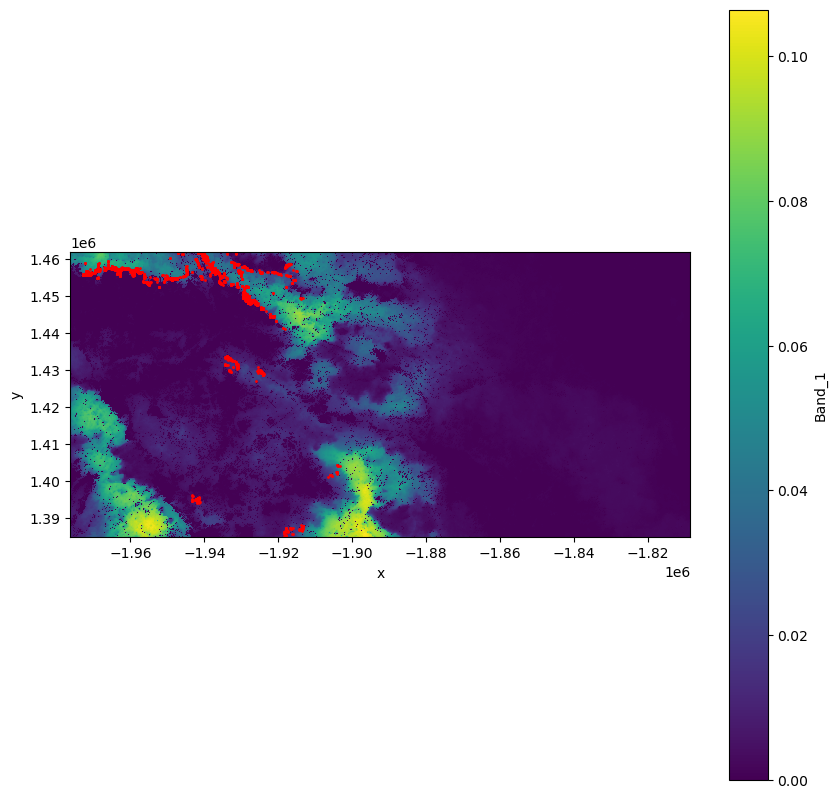

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))
riley['2011'].sel(x=slice(x_min, x_max), y=slice(y_max, y_min)).BP.plot(ax=ax)
subset.plot(ax=ax, color='red', markersize=1)
# plt.title("Burned Structures Located in box in Northern California")
plt.show()

In [9]:
eaton = load_structures_destroyed(fire_name='Eaton', target_crs='EPSG:5070')
eaton.head()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,DAMAGE,STREETNUMBER,STREETNAME,STREETTYPE,STREETSUFFIX,CITY,STATE,ZIPCODE,CALFIREUNIT,COUNTY,...,UTILITYMISCSTRUCTUREDISTANCE,FIRENAME,APN,ASSESSEDIMPROVEDVALUE,YEARBUILT,SITEADDRESS,GLOBALID,Latitude,Longitude,geometry
0,No Damage,2190,Grand Oaks,Avenue,blding B,Altadena,CA,91001,LAC,Los Angeles,...,None,None,5857023020,405135.0,1949,"2190 GRAND OAKS AVE, ALTADENA, CA 91001",{9C878AA1-F6E9-4293-86AB-0052CD254B79},34.183522,-118.102419,POINT (-2003706.71 1469551.713)
1,Destroyed (>50%),512,Devirian,Place,None,Altadena,CA,91001,LAC,Los Angeles,...,None,None,5829023028,173839.0,1942,"512 DEVIRIAN PL, ALTADENA, CA 91001",{9362C772-8783-4D90-8F42-00622B25CBB2},34.196158,-118.158133,POINT (-2008339.347 1472102.18)
2,No Damage,2211,N Altadena,Drive,blding B,Altadena,CA,91001,LAC,Los Angeles,...,None,None,5857022060,286620.0,1937,"2211 N ALTADENA DR, ALTADENA, CA 91001",{21D11BA8-9278-483B-B091-00BA3C2F2C9C},34.183466,-118.100784,POINT (-2003562.615 1469511.146)
3,No Damage,1900,N Altadena,Drive,None,Pasadena,CA,91107,LAC,Los Angeles,...,None,None,5857017004,100224.0,1953,"1900 N ALTADENA DR, PASADENA, CA 91107",{E4E2B8A2-8230-48D2-887B-00C23103BDEB},34.178690,-118.099171,POINT (-2003542.127 1468957.669)
4,No Damage,1918,Braeburn,Road,None,Altadena,CA,91001,LAC,Los Angeles,...,None,None,5857032003,301336.0,1926,"1918 BRAEBURN RD, ALTADENA, CA 91001",{5324C9C0-3385-4FA6-8171-00EB77B3FDC5},34.187668,-118.110852,POINT (-2004350.51 1470180.51)


In [10]:
x_min, x_max = eaton.geometry.x.min(), eaton.geometry.x.max()
y_min, y_max = eaton.geometry.y.min(), eaton.geometry.y.max()

In [11]:
slice(x_min, x_max)

slice(-2008804.8749751963, -1996365.3631639928, None)

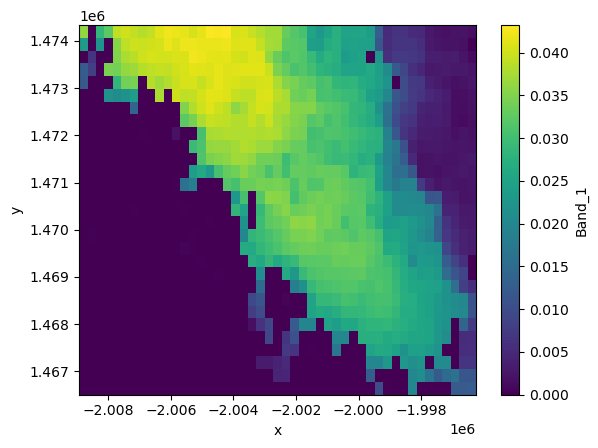

In [12]:
riley['2011'].sel(x=slice(x_min, x_max), y=slice(y_max, y_min)).BP.plot();

In [13]:
important_days = catalog.get_dataset('era5-fire-weather-days').to_xarray(
    is_icechunk=False, xarray_open_kwargs={'engine': 'zarr'}
)

In [14]:
important_days.sel(latitude=34.17, longitude=-118.09, method='nearest')

<xarray.Dataset> Size: 4MB
Dimensions:                                       (time: 262968)
Coordinates:
    latitude                                      float32 4B 34.25
    longitude                                     float32 4B 235.0
  * time                                          (time) datetime64[ns] 2MB 1...
Data variables:
    10m_wind_gust_since_previous_post_processing  (time) float32 1MB ...
    sfcWindfromdir                                (time) float32 1MB ...

In [15]:
def plot_windrose(winddir, windspeeds, bins=np.arange(0, 20, 1), title='Wind gusts (m/s)'):
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'windrose'})
    ax.bar(
        winddir.values, windspeeds.values, bins=bins, normed=True, opening=0.8, edgecolor='white'
    )

    # Customize the plot
    ax.set_legend(title=title)

    return fig, ax

In [16]:
def lon_to_180(ds):
    lon = ds['longitude'].where(ds['longitude'] < 180, ds['longitude'] - 360)
    ds = ds.assign_coords(longitude=lon)
    return ds

Text(0.5, 0.98, '34.17, -118.09')

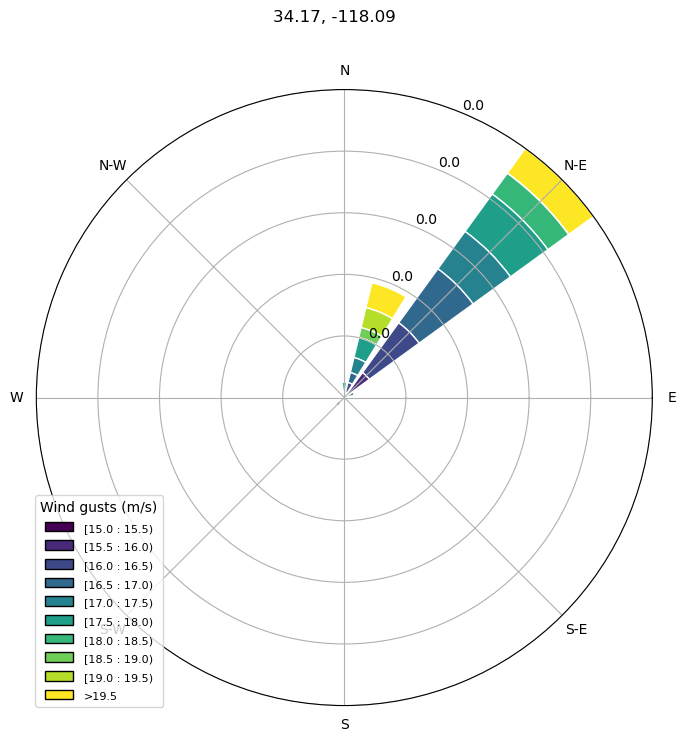

In [17]:
lat = 34.17
lon = -118.09
important_days_to_plot = (
    lon_to_180(important_days).sel(latitude=lat, longitude=lon, method='nearest').compute()
)
fig, ax = plot_windrose(
    important_days_to_plot['sfcWindfromdir'],
    important_days_to_plot['10m_wind_gust_since_previous_post_processing'],
    bins=np.arange(15, 20, 0.5),
)
fig.suptitle(f'{lat}, {lon}')

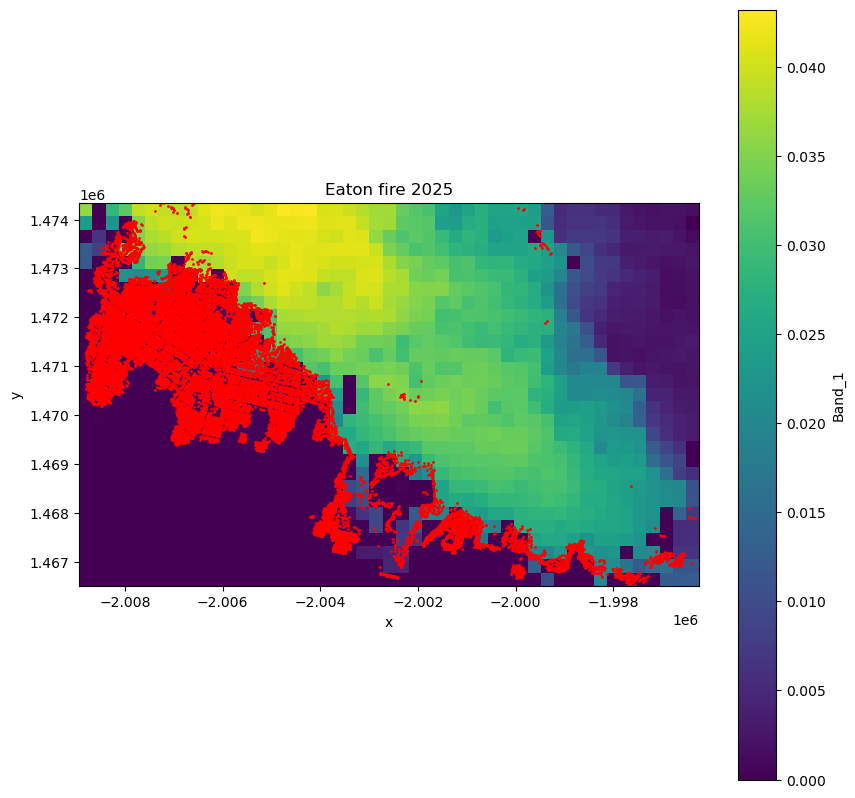

In [18]:
fig, ax = plt.subplots(figsize=(10, 10))
riley['2011'].sel(
    x=slice(x_min, x_max),
    y=slice(y_max, y_min),
).BP.plot(ax=ax)
eaton.plot(ax=ax, color='red', markersize=1)
plt.title('Eaton fire 2025');

In [19]:
# Step 5: Load California boundary (state outline) using Geopandas' built-in datasets
california = gpd.read_file(geodatasets.get_path('naturalearth land'))
# california = california[california.name == 'California']

# # Step 6: Filter out points within California's boundaries
# gdf_ca = gdf[gdf.geometry.within(california.geometry.iloc[0])]